# Data preparation

In [ ]:
import pandas as pd
import numpy as np
import os
import os.path


directory='/home/jimbrootan/Desktop/bbc'
print('DIRECTRY PATH: ',directory)
folders= os.listdir(directory)
print('BBC FOLDER DETAILS AS LIST: ',folders)
os.chdir(directory)
os.getcwd()

In [ ]:
'''Listed all the directories to the path'''

path=[]
for i in folders:
    path.append(os.getcwd()+'/'+i)

In [ ]:
"creating 2 lists to append the news type and news "


news=[]
news_type=[]
filename=[]
for paths in path:
    for file_name in os.listdir(paths):
        with open(paths+'/'+file_name,'r',encoding='latin') as f:
            data=f.read()
            data = data.replace("\n"," ").replace('\r','')
            news.append(data)
            f.close()
        news_type.append(os.path.basename(paths))
DataFrame=pd.DataFrame({'Category':news_type,'News':news
                       })

DataFrame.head()

DataFrame.to_csv('/home/jimbrootan/Desktop/bbc/bbc_news.csv',index=False)

# import Modules


In [1]:
import pandas as pd #data processing and file loading
import numpy as np #linear algibra
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from tqdm import tqdm
import re



 # Loading data from BBC dataset

In [16]:
df=pd.read_csv('/home/jimbrootan/Desktop/bbc/bbc_news.csv')
df.head()


,Category,News
0,tech,Mobile picture power in your pocket How many ...
1,tech,"When technology gets personal In 2020, whippi..."
2,tech,Mobiles rack up 20 years of use Mobile phones...
3,tech,Parents face video game lessons Ways of ensur...
4,tech,Digital guru floats sub-$100 PC Nicholas Negr...


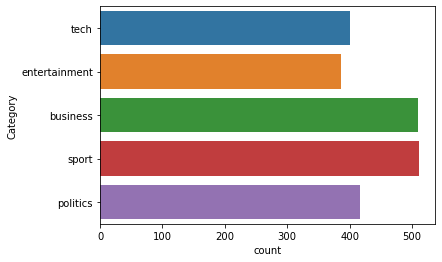

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

In [3]:
sns.countplot(y=df['Category'])
plt.show()
df['Category'].value_counts()

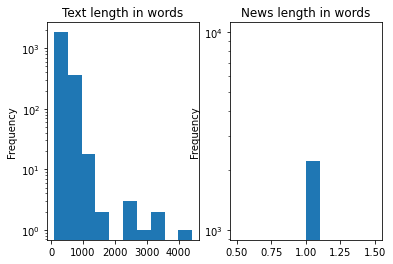

In [4]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
df['News'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Text length in words');
plt.subplot(1, 2, 2)
df['Category'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('News length in words');

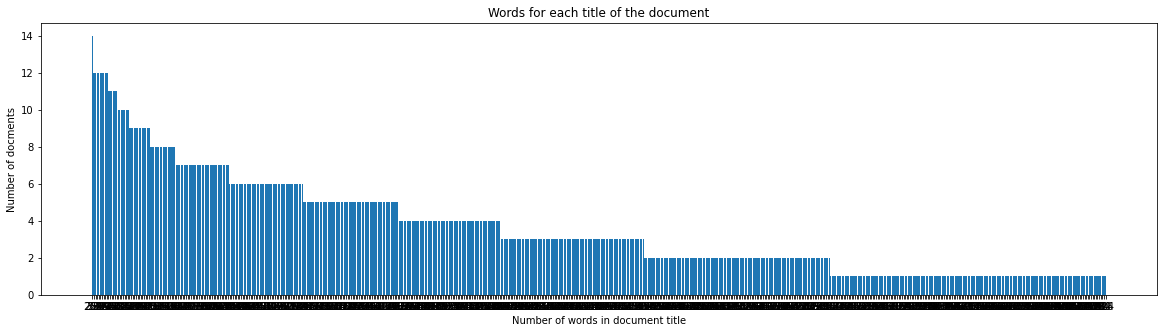

In [5]:
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
word_dict = dict(df['News'].str.split().apply(len).value_counts())
word_dict
idx = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(idx, list(word_dict.values()))
plt.ylabel('Number of docments')
plt.xlabel('Number of words in document title')
plt.title('Words for each title of the document')
plt.xticks(idx, list(word_dict.keys()))
plt.show()

In [6]:
possible_labels = df.Category.unique()
possible_labels

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict
df['label'] = df.Category.replace(label_dict)
y=df['label']


#   Remove Non-Alphanumeric Characters
#   Convert to Lowercase
#   Remove Stopwords

In [7]:
stopword = set(stopwords.words('english'))
# print(stopword)
def clear_text(text):
    #reference: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\t', ' ')
    text = text.replace('\\n', ' ')
    text = ' '.join(word for word in text.split() if word not in stopword)

    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower()
    return text
    
processed_titles= []
for title in tqdm(df['News'].values):
    processed_title = clear_text(title)
    processed_titles.append(processed_title)

100%|██████████| 2225/2225 [00:02<00:00, 929.25it/s] 


# Wordcloud

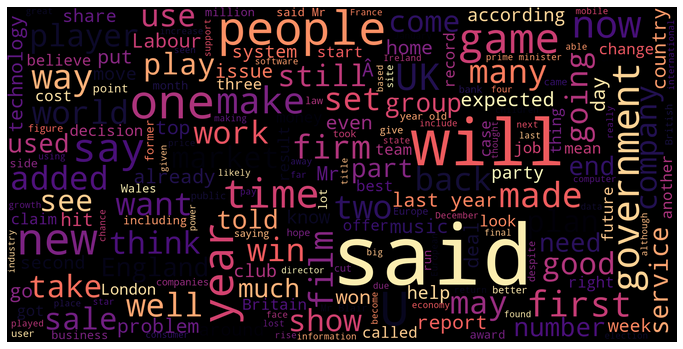

In [8]:
text = " ".join(review for review in df.News)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

# Modeling Training and Evaluation
2.1 TF-IDF
Term Frequency, Inverse Document Frequecy: Method for determining how important a word is to the overall corpus of news articles.$$ tf = \frac{f_{t}}{\sum f_{t}}$$
$$ idf = \frac{log(N)}{n_{t}} $$
$$ tf idf = tf * idf $$
$$ = \frac{f_{t}}{\sum f_{t}} * \frac{log(N)}{n_{t}} $$

In [17]:
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(processed_titles)
print("Shape encodig ",X.shape)

X


Shape encodig  (2225, 9391)


<2225x9391 sparse matrix of type '<class 'numpy.float64'>'
	with 337058 stored elements in Compressed Sparse Row format>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state=9
                                                   )

# Model Creation oneVsrest Classifier

In [11]:
perform_list = []
def model_selection(model_name):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'SVC':
        mdl = SVC()
   
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(X_train,y_train)
    y_pred = oneVsRest.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))



# performance metrics

In [12]:
model_selection('Logistic Regression')

Test Accuracy Score of Basic Logistic Regression: % 97.08
Precision : 0.9707865168539326
Recall    : 0.9707865168539326
F1-score   : 0.9707865168539326


In [13]:
model_selection('Random Forest')

Test Accuracy Score of Basic Random Forest: % 97.3
Precision : 0.9730337078651685
Recall    : 0.9730337078651685
F1-score   : 0.9730337078651685


In [14]:
model_selection('SVC')

Test Accuracy Score of Basic SVC: % 97.75
Precision : 0.9775280898876404
Recall    : 0.9775280898876404
F1-score   : 0.9775280898876404


In [15]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.08,0.97,0.97,0.97
1,Random Forest,97.30,0.97,0.97,0.97
2,SVC,97.75,0.98,0.98,0.98
